# Example to Load and Generate Fast Calorimeter Simulation Dataset

By L. Tang, Based on [CaloDiffusion](https://github.com/OzAmram/CaloDiffusionPaper)

# Background
Calorimeter is one of the important detector in high energy physics experiment. As the name noted, this kind of instrument is used to measure the energy of particle, by monitoring the heat, flash light, discharge or other output between energitic particle and calorimeter active material.

This kind of detector is also widely used in medical science, e.g. the main and largest part of CT and PET is some kind of calorimeter in order to measure the x-ray or other particle and to identify medical observation.

The calorimeter of collider experiment looks like (from CERN)

![](https://mediaarchive.cern.ch/MediaArchive/Photo/Public/2008/0803015/0803015_01/0803015_01-A5-at-72-dpi.jpg)

And the one used in PET (from wiki)

![](https://upload.wikimedia.org/wikipedia/commons/f/fc/PET-detectorsystem_2.png)

The calorimeter data should be compared with simulation in order to study the real physics and identified the underlaying process. In that sense almost all the collider study need to generate or simulate the particle interaction with calorimeter, not only in the R&D of this detector but also in the period of data taking and data analysis.

Triditional way to simulate this process involves the "showering", one particle could split into thousands of thousands secondary particles when they fly in the calorimeter and hit material. The compution is huge since it is "Markov Chain Monte Carlo" process and could not be well paralleled. like the plot (from Sven Menke@MPP)

![](https://www.mppmu.mpg.de/~menke/elss/gifs/fe24elwhite_small.gif)

Fast calo sim project aim to design generative machine learning method to directly sampled the output of calorimeter, based on the incident particle, and bypass the hugh computing effort. It could save more than millions of core-hours and euros if finally applied, e.g. in ATLAS experiment.

# Prepare Dataset

The dataset could be found on [official website](https://calochallenge.github.io/homepage/)

In [1]:
%cd "C:\Users\tangd\zz-Internship"
dataset_photons_train = 'CaloChallenge/Datasets/dataset_1_photons_1.hdf5'
dataset_pions_train = 'CaloChallenge/Datasets/dataset_1_pions_1.hdf5'

C:\Users\tangd\zz-Internship


# Inspect the dataset and Understand the structure

In [2]:
import h5py as h5
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib as mpl

In [3]:
f_photons=h5.File(dataset_photons_train)
print(f_photons['incident_energies'].shape) # condition
print(f_photons['showers'].shape) # data to be generated

f_pions=h5.File(dataset_pions_train)
print(f_pions['incident_energies'].shape) # condition
print(f_pions['showers'].shape) # data to be generated


(121000, 1)
(121000, 368)
(120230, 1)
(120230, 533)


In [4]:
# we can access the geometry of the dataset here
%cd CaloChallenge/code
import XMLHandler
from HighLevelFeatures import HighLevelFeatures as HLF

HLF_1_photons = HLF('photon', filename='binning_dataset_1_photons.xml')
HLF_1_pions = HLF('pion', filename='binning_dataset_1_pions.xml')


HLF_1_photons.CalculateFeatures(f_photons["showers"][:])
HLF_1_pions.CalculateFeatures(f_pions["showers"][:])

C:\Users\tangd\zz-Internship\CaloChallenge\code


### Geometry
Here, HLF contains the geometry we need. hlf.num_alpha gives us the number of angular bins in every layer, while the radii within each layer can be found in hlf.r_edges

In [5]:
## For instance, with the 5 layer photon dataset:

print(HLF_1_photons.num_alpha)
## gives the number of angular bins in each layer

for i in range(len(HLF_1_photons.relevantLayers)):
    print(HLF_1_photons.r_edges[i])
## gives the radii within each layer

[1, 10, 10, 1, 1]
[0.0, 5.0, 10.0, 30.0, 50.0, 100.0, 200.0, 400.0, 600.0]
[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0, 20.0, 30.0, 40.0, 50.0, 70.0, 90.0, 120.0, 150.0, 200.0]
[0.0, 2.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 40.0, 50.0, 60.0, 80.0, 100.0, 130.0, 160.0, 200.0, 250.0, 300.0, 350.0, 400.0]
[0.0, 50.0, 100.0, 200.0, 400.0, 600.0]
[0.0, 100.0, 200.0, 400.0, 1000.0, 2000.0]


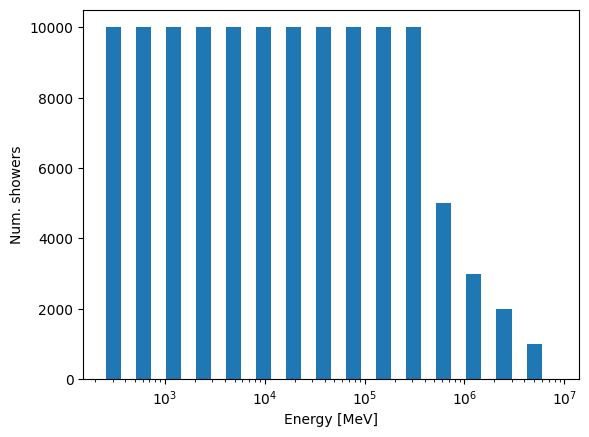

In [6]:
# incident energies are discrete, starting at 256 MeV and increasing in powers of 2. At high energies,
# there are fewer than 10k events per energy 
energies = f_photons['incident_energies'][:]

bins = np.logspace(8,23,31, base=2)
plt.hist(energies, bins=bins)
plt.xscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Num. showers')
plt.show()

One way showers could look like is with this following code. I like the color of [this one](https://github.com/qibin2020/calosim_intro) better

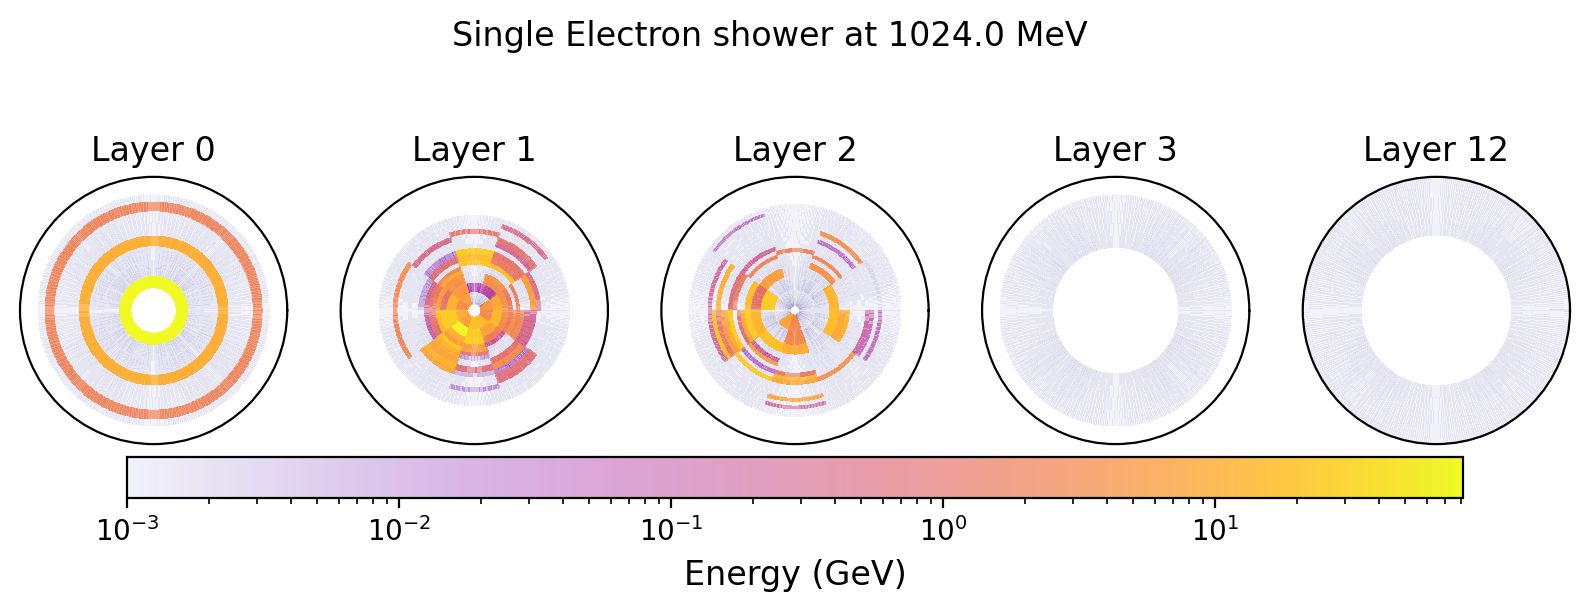

In [8]:
from matplotlib.colors import LogNorm as LN
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def bettert_cmap():
    # misc staff to make colormap better
    from matplotlib.colors import ListedColormap
    # Choose colormap which will be mixed with the alpha values
    cmap = plt.cm.afmhot_r

    # Get the colormap colors
    my_cmap = cmap(np.arange(cmap.N))
    # Define the alphas in the range from 0 to 1
    alphas = np.linspace(0, 1, cmap.N)
    # Define the background as white
    BG = np.asarray([1., 1., 1.,])
    # Mix the colors with the background
    for i in range(cmap.N):
        my_cmap[i,:-1] = my_cmap[i,:-1] * alphas[i] + BG * (1.-alphas[i])
    # Create new colormap which mimics the alpha values
    my_cmap = ListedColormap(my_cmap)
    cmap = plt.cm.plasma
    cmap = cmap(np.arange(cmap.N))
    cmap[:, 3] = np.linspace(0.05, 1, 256)
    cmap = ListedColormap(cmap)
    return cmap



def plot_shower(x,hlf,title,ievt=123):
    
    data = x[ievt]
    
    vmax = data.max()
    vmin = 1e-3 if data.max() >= 1 else data.max()/1000.
    
    
    figsize = (len(hlf.relevantLayers)*2, 3)
    fig = plt.figure(figsize=figsize, dpi=200)
    
    
    num_splits = 400
    layer_boundaries = np.unique(hlf.bin_edges)
    max_r = 0
    for radii in hlf.r_edges:
        if radii[-1] > max_r:
            max_r = radii[-1]
    
    for idx, layer in enumerate(hlf.relevantLayers):
        radii = np.array(hlf.r_edges[idx])
        radii = np.log(radii[1:])
        alpha = hlf.num_alpha[idx]
        theta, rad = np.meshgrid(np.linspace(0, 2*np.pi, num_splits), radii)
        
        
        pts_per_angular_bin = int(num_splits / alpha)
        
        
        data_reshaped = data[layer_boundaries[idx]:layer_boundaries[idx+1]].reshape(
            int(alpha), -1)
        data_repeated = np.repeat(data_reshaped, (pts_per_angular_bin), axis=0)
        
        
        ax = plt.subplot(1, len(hlf.r_edges), idx+1, polar=True)
        ax.grid(False)
        pcm = ax.pcolormesh(theta, rad, data_repeated.T+1e-16, norm=LN(vmin=vmin, vmax=vmax), cmap = bettert_cmap())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

        ax.set_rmax(np.log(max_r))
        ax.set_title('Layer '+str(layer))
            
    wdth = str(len(hlf.r_edges)*100)+'%'
    axins = inset_axes(fig.get_axes()[len(hlf.r_edges)//2], width=wdth,
                        height="15%", loc='lower center', bbox_to_anchor=(0., -0.2, 1, 1),
                        bbox_transform=fig.get_axes()[len(hlf.r_edges)//2].transAxes,
                        borderpad=0)
    cbar = plt.colorbar(pcm, cax=axins, fraction=0.2, orientation="horizontal")
    cbar.set_label(r'Energy (GeV)', y=0.83, fontsize=12)
    plt.gcf().suptitle("Single Electron shower at {:.1f} MeV".format(f_photons['incident_energies'][ievt][0]))
            
plot_shower(f_photons['showers'],HLF_1_photons, f_photons['incident_energies'])

But there's a built-in method in HighLevelFeatures

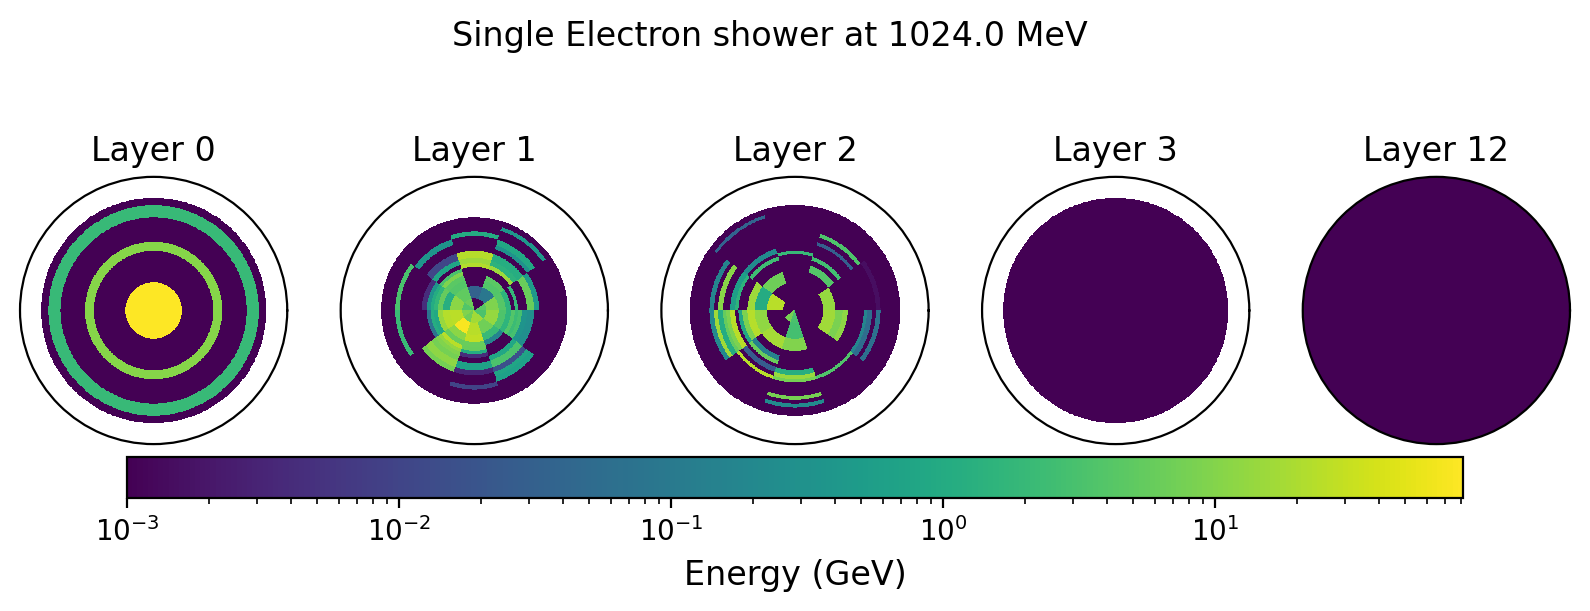

In [9]:
from HighLevelFeatures import HighLevelFeatures as HLF

_ = HLF_1_photons.DrawSingleShower(f_photons['showers'][123], filename=None, 
                                title="Single Electron shower at {:.1f} MeV".format(f_photons['incident_energies'][123][0]))


# Generate showers from trained models

In [10]:
%cd "C:\Users\tangd\zz-Internship\scripts"

C:\Users\tangd\zz-Internship\scripts


In [6]:
%run plot.py \
            --config ../configs/config_dataset1_photon.json \
            --model_loc ../trained_models/dataset1_photon.pth \
            --data_folder ../CaloChallenge/Datasets/ \
            --sample \
            --sample_steps 400 \
            --sample_offset 2 \
            --nevts 61000 \
            -g generated_photons_2.h5

Creating plot directory ../plots
Event start, stop:  0 61000
dset 11
DATA mean, std tensor(-0.0016) tensor(1.0007)
Loading Diffu model from ../trained_models/dataset1_photon.pth


 Model: 

SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.07773494720459 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.7535674571991 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.88311457633972 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.31783199310303 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 37.22151732444763 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.910953521728516 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.38295102119446 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.95308303833008 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.85407066345215 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.80623245239258 seconds
SAMPLE ALGO : ddpm
Time for sampling 100

SAMPLE ALGO : ddpm
Time for sampling 100 events is 37.32480335235596 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.53785729408264 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.5392861366272 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.64769673347473 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.81148624420166 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.802175760269165 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.26085329055786 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.411808013916016 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.33389472961426 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.554407835006714 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.18611121177673 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 37.49639868736267 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.94960141181946 secon

Time for sampling 100 events is 36.463613510131836 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.36901831626892 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.42740988731384 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.64538908004761 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.69934034347534 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.52794575691223 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.38568615913391 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.65200352668762 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.56837558746338 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.914860010147095 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.982521533966064 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.002341985702515 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.940287351608276 seconds
SAMPLE ALGO :

SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.30949831008911 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.151124477386475 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.020434856414795 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.96425986289978 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.99809169769287 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.97712564468384 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.98205542564392 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.97128391265869 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.001830101013184 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.99862241744995 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.992780685424805 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.005242347717285 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.96756052970886 se

Time for sampling 100 events is 35.952786922454834 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.96850872039795 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.94776654243469 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.9325156211853 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.02840971946716 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.014814376831055 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.91239356994629 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.932693004608154 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.96014094352722 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.99303579330444 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.95470356941223 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.96047925949097 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.95415377616882 seconds
SAMPLE ALGO : dd

SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.977107524871826 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.09970808029175 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.99234342575073 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.960485219955444 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.952712297439575 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.00115084648132 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 35.97904586791992 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.01592421531677 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 37.235063791275024 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 38.73546600341797 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 37.29568648338318 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 37.14513444900513 seconds
SAMPLE ALGO : ddpm
Time for sampling 100 events is 36.95643210411072 sec

## What do they look like?

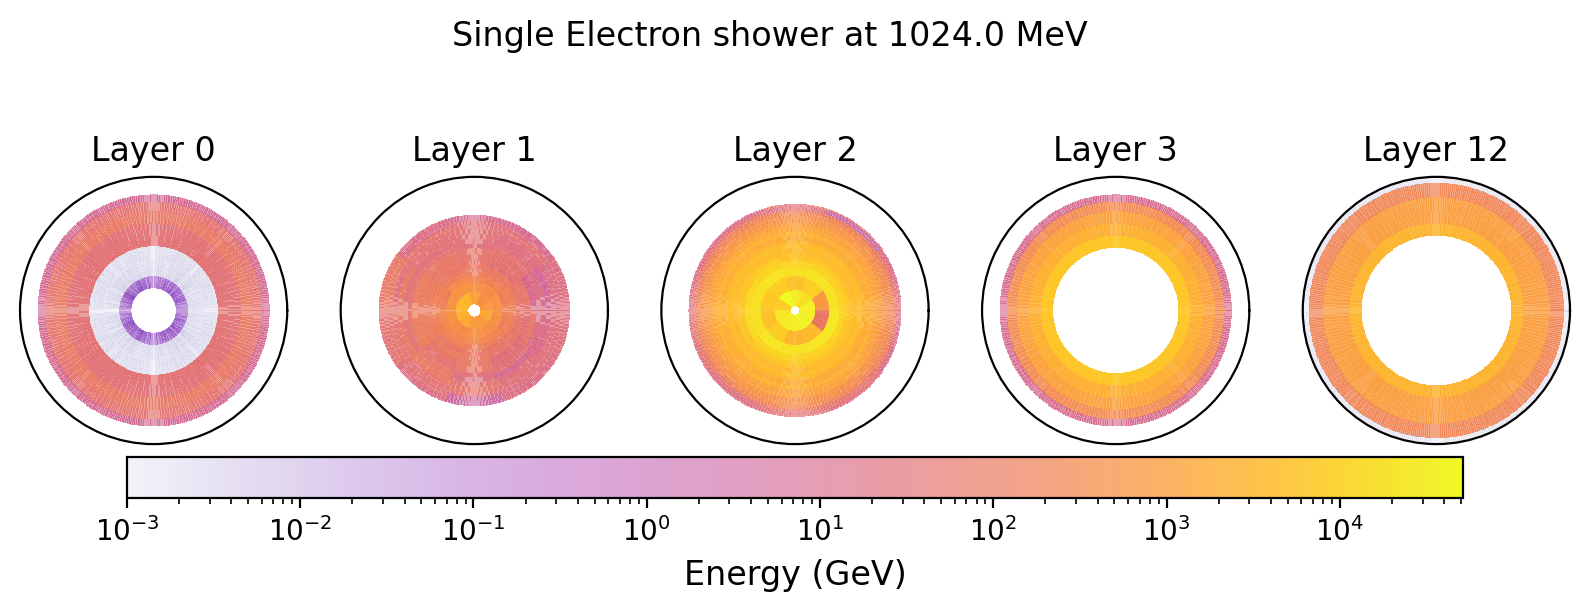

In [12]:
dataset_photons_gen = 'generated_photons.h5'
f_gen=h5.File(dataset_photons_gen)


HLF_1_photons_gen = HLF('photon', filename='../CaloChallenge/code/binning_dataset_1_photons.xml')
HLF_1_photons_gen.CalculateFeatures(f_gen["showers"][:])

plot_shower(f_gen['showers'],HLF_1_photons_gen,f_gen['incident_energies'])

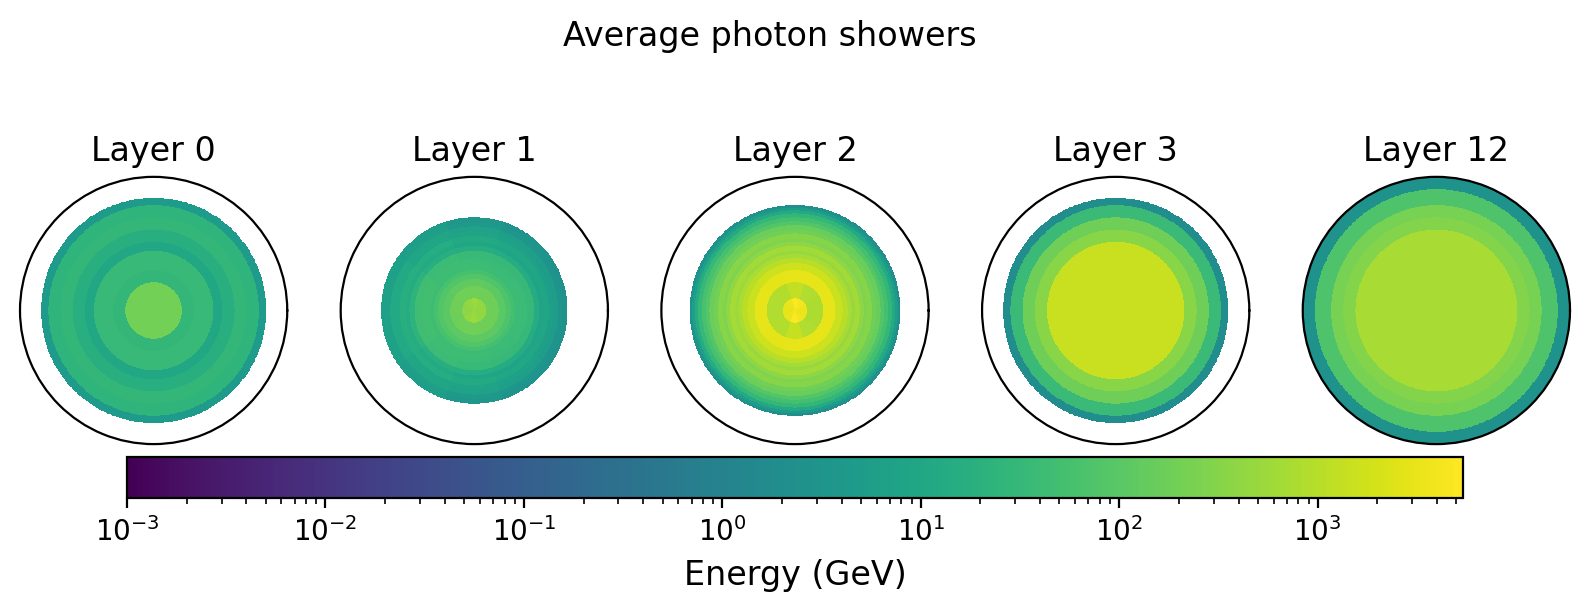

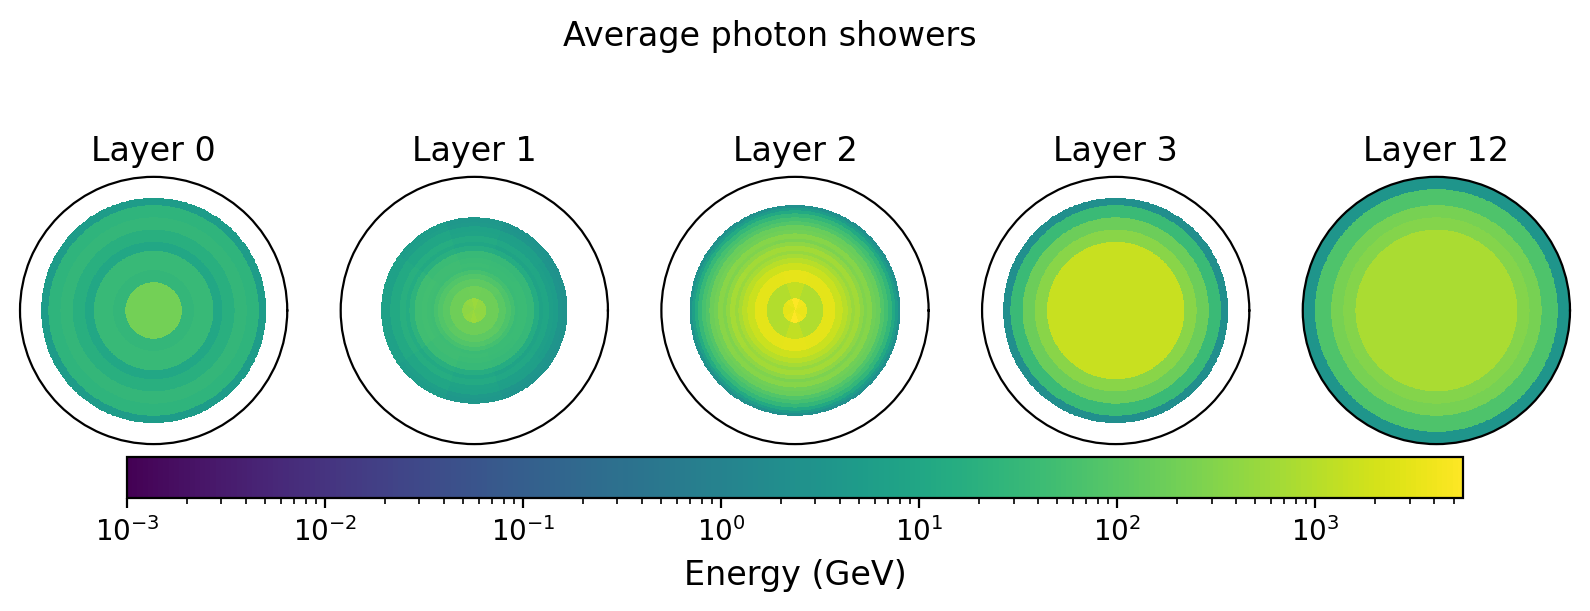

In [13]:
_ = HLF_1_photons_gen.DrawAverageShower(f_gen['showers'][:], filename=None, title="Average photon showers")
_ = HLF_1_photons.DrawAverageShower(f_photons['showers'][:], filename=None, title="Average photon showers")

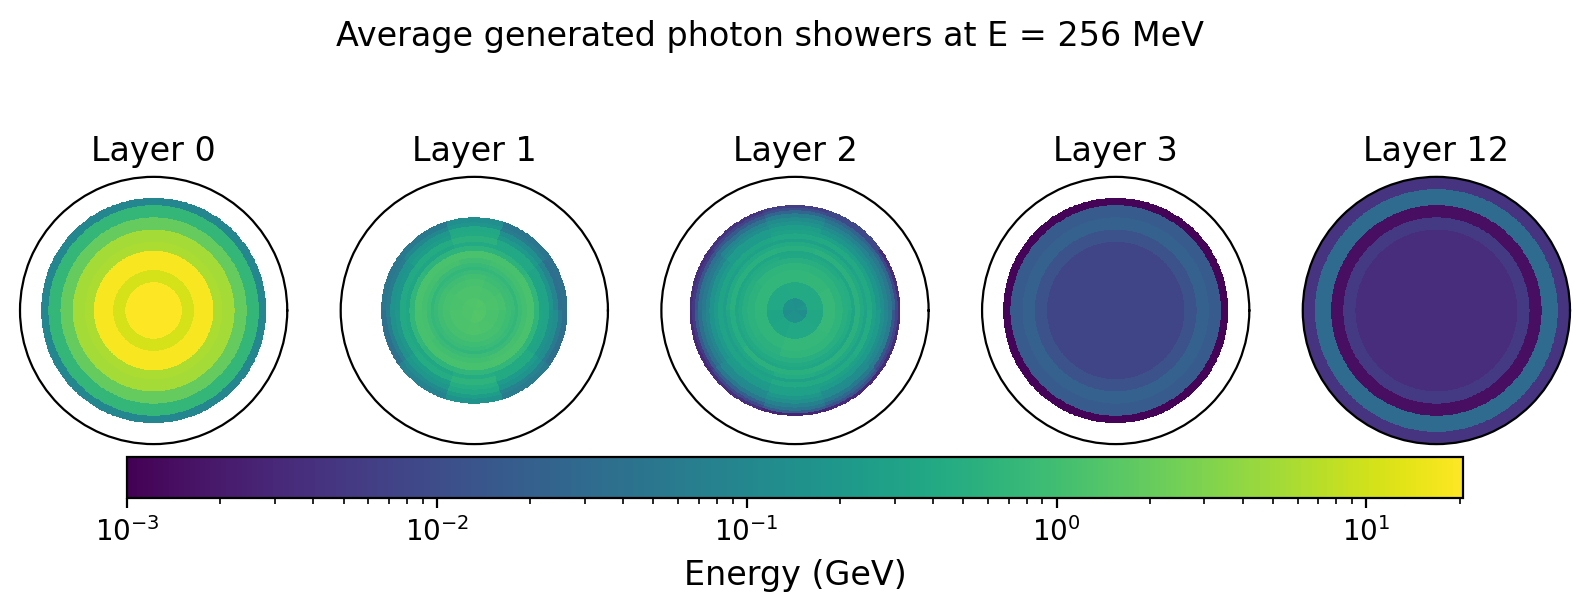

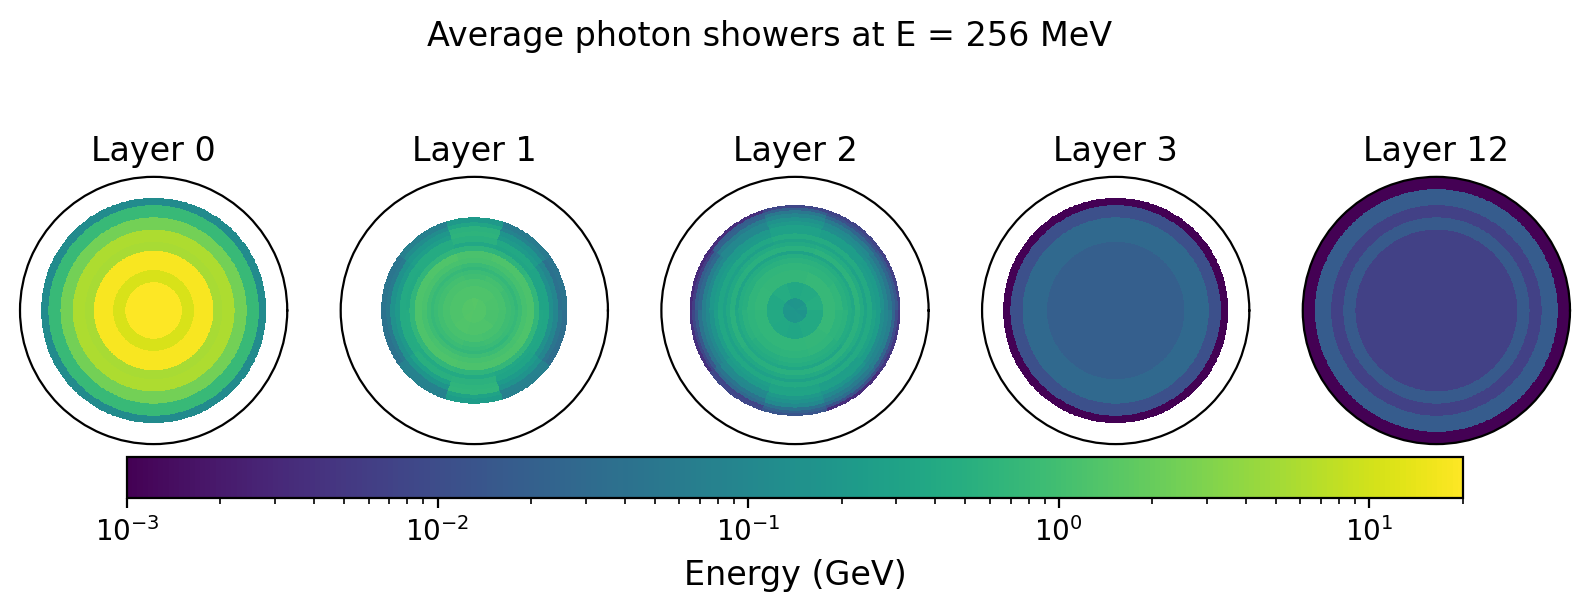

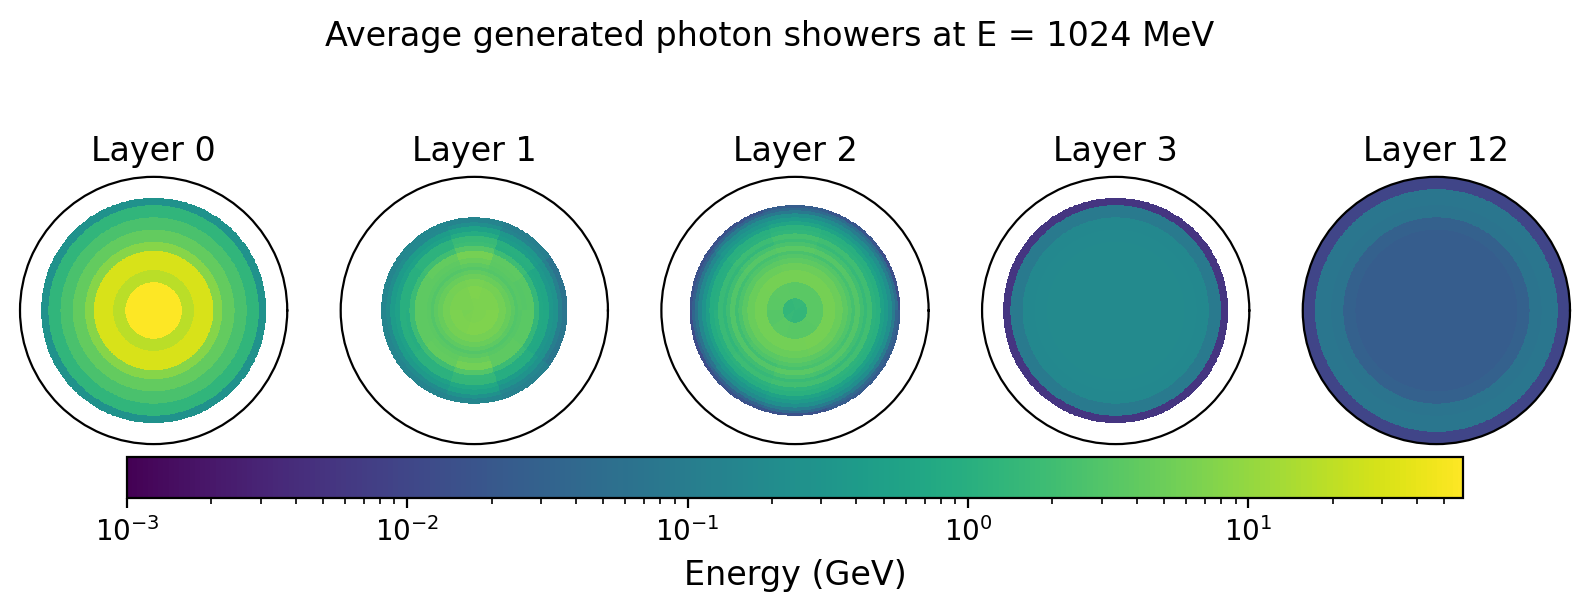

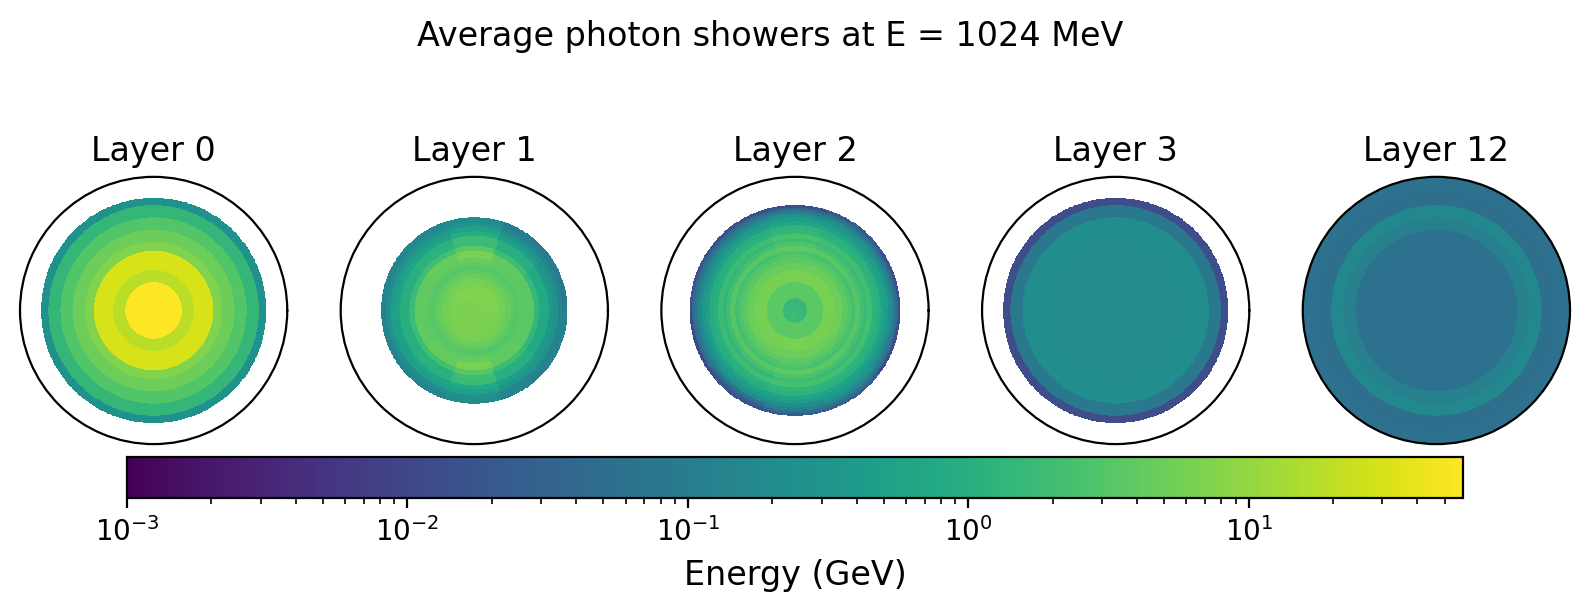

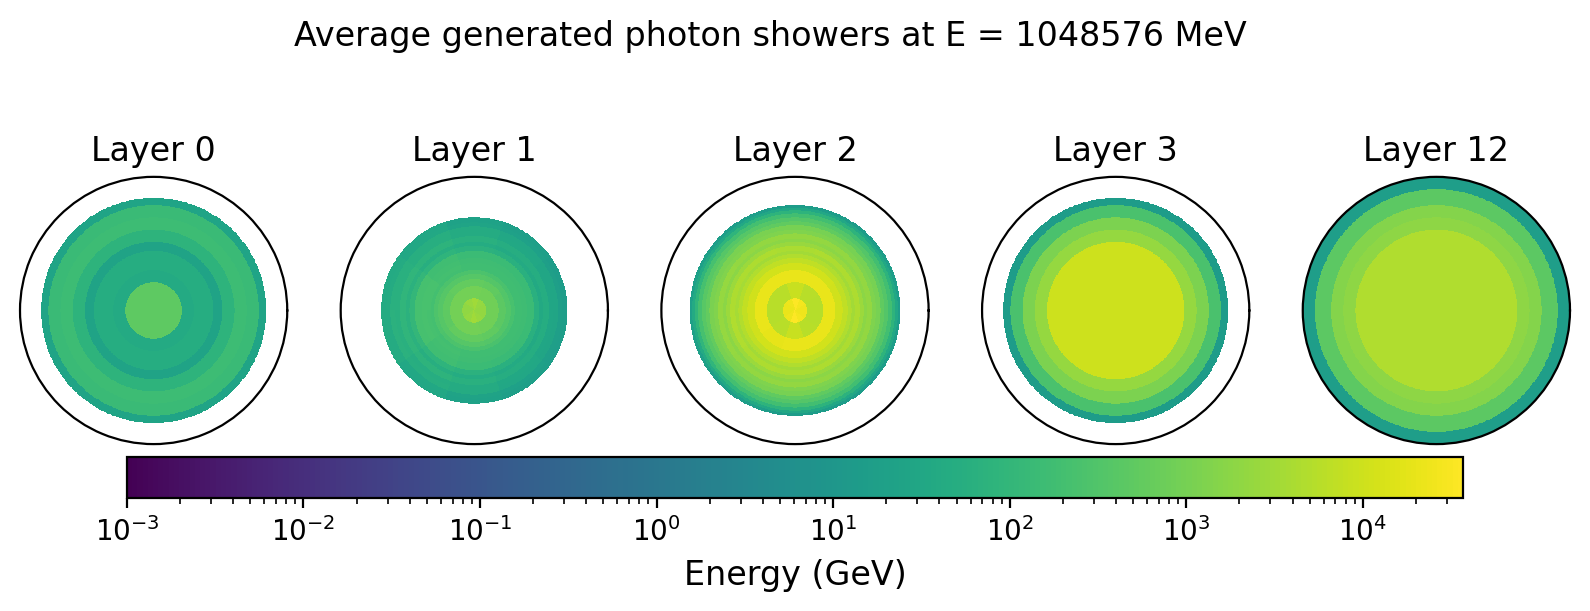

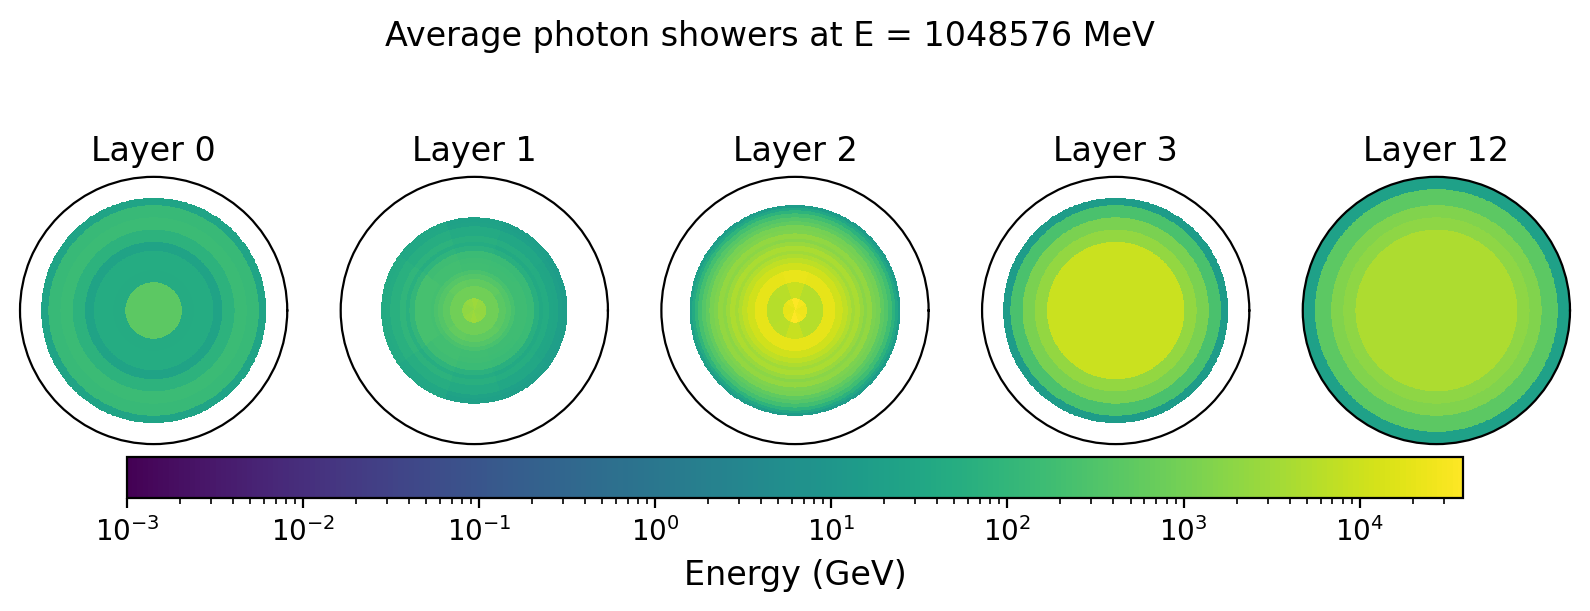

In [15]:
gen_energies = np.round(f_gen['incident_energies'][:]).astype(float)

for energy in [256, 1024, 1048576]:
    voxel_dim = f_photons['showers'].shape[1]
    voxel_dim_gen = f_gen['showers'].shape[1]
    # hdf5 indexing must match the shape of the dataset:
    energy_idx = np.tile(f_photons['incident_energies'][:]==energy, voxel_dim)
    energy_idx_gen = np.tile(gen_energies==energy, voxel_dim_gen)
    # and then be reshaped:
    _ = HLF_1_photons_gen.DrawAverageShower(f_gen['showers'][energy_idx_gen].reshape(-1, voxel_dim_gen), 
                                        filename=None, title="Average generated photon showers at E = {} MeV".format(energy))

    _ = HLF_1_photons.DrawAverageShower(f_photons['showers'][energy_idx].reshape(-1, voxel_dim), 
                                        filename=None, title="Average photon showers at E = {} MeV".format(energy))
    

In [16]:
# We can see the distribution of energies

unique_elements, counts = np.unique(gen_energies, return_counts=True)

# Print the unique elements and their counts
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count}")

256.0: 10112
512.0: 10084
1024.0: 9971
2048.0: 9980
4096.0: 9959
8192.0: 10018
16384.0: 10036
32768.0: 10032
65536.0: 9988
131072.0: 9949
262144.0: 9977
524288.0: 4985
1048576.0: 2992
2097153.0: 1933
4194304.0: 984


# Evaluation

In [1]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

### This is the histogram separation based evaluation

In [17]:
%cd "C:\Users\tangd\zz-Internship\CaloChallenge\code"
%run evaluate.py \
            --input_file ../Datasets/dataset_1_photons_2.hdf5\
            --reference_file ../../scripts/generated_photons.h5\
            --mode hist \
            --dataset 1-photons \
            --output_dir eval_metrics_004

C:\Users\tangd\zz-Internship\CaloChallenge\code
Checking if input file has the correct form ...
Found 121000 events in the file.
Checking if input file has the correct form: DONE 

Extracting showers from input file ...
Extracting showers from input file: DONE.

Storing reference .pkl file in folder: ../../scripts
Checking if reference file has the correct form ...
Found 121000 events in the file.
Checking if reference file has the correct form: DONE 

Extracting showers from reference file ...
Extracting showers from reference file: DONE.

Computing .pkl reference
Saving file with high-level features.
Saving file with high-level features DONE.
Calculating high-level features for histograms ...
Saving file with high-level features.
Saving file with high-level features DONE.
Calculating high-level features for histograms: DONE.

Plotting histograms ...
Separation power of Etot / Einc histogram: 0.025890069521876703
Separation power of E layer 0 histogram: 0.0032047853363786735
Separatio

C:\Users\tangd\zz-Internship\CaloChallenge\code\evaluate_plotting_helper.py:589: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Separation power of voxel distribution histogram: 1.2668170668880266e-05
Plotting histograms: DONE. 



### This is the Classifier based evaluation

In [18]:
%cd "C:\Users\tangd\zz-Internship\CaloChallenge\code"
%run evaluate.py \
            --input_file ../Datasets/dataset_1_photons_2.hdf5\
            --reference_file ../../scripts/generated_photons.h5\
            --mode cls-low \
            --dataset 1-photons \
            --output_dir eval_metrics_004

C:\Users\tangd\zz-Internship\CaloChallenge\code
Checking if input file has the correct form ...
Found 121000 events in the file.
Checking if input file has the correct form: DONE 

Extracting showers from input file ...
Extracting showers from input file: DONE.

Storing reference .pkl file in folder: ../../scripts
Checking if reference file has the correct form ...
Found 121000 events in the file.
Checking if reference file has the correct form: DONE 

Extracting showers from reference file ...
Extracting showers from reference file: DONE.

Loading .pkl reference
Loading file with high-level features.
Calculating high-level features for classifier ...
Calculating high-level features for classifer: DONE.

Extracting showers from 0.0 file ...
Extracting showers from 0.0 file: DONE.

Extracting showers from 1.0 file ...
Extracting showers from 1.0 file: DONE.

Using cuda:0
DNN(
  (inputlayer): Linear(in_features=369, out_features=512, bias=True)
  (outputlayer): Linear(in_features=512, ou

Epoch  25 / 50, step   73 / 146; loss 0.6129
Accuracy on training set is 0.611404958677686
Accuracy on test set is 0.5501446280991735
AUC on test set is 0.580615054470323
BCE loss of test set is 0.7324, JSD of the two dists is -0.0567
Epoch  26 / 50, step    0 / 146; loss 0.6238
Epoch  26 / 50, step   73 / 146; loss 0.6203
Accuracy on training set is 0.6251170798898071
Accuracy on test set is 0.5552892561983471
AUC on test set is 0.589728121371491
BCE loss of test set is 0.7397, JSD of the two dists is -0.0671
Epoch  27 / 50, step    0 / 146; loss 0.6116
Epoch  27 / 50, step   73 / 146; loss 0.6007
Accuracy on training set is 0.6387741046831956
Accuracy on test set is 0.5527479338842975
AUC on test set is 0.5897614848712519
BCE loss of test set is 0.7597, JSD of the two dists is -0.0961
Epoch  28 / 50, step    0 / 146; loss 0.6164
Epoch  28 / 50, step   73 / 146; loss 0.5839
Accuracy on training set is 0.6430371900826446
Accuracy on test set is 0.5805785123966942
AUC on test set is 0.6

The closer the accuracy is to 50% and the lower the AUC is, the better.